#**Regression Analysis**

1. Importing Packages

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.stattools import durbin_watson as dw
from scipy.stats.stats import pearsonr
from scipy.special import ndtri
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2. Load Data

Source: https://www.kaggle.com/c/boston-housing

In [9]:
from sklearn import datasets ## imports datasets from scikit-learn
data = datasets.load_boston() ## loads Boston dataset from datasets library 

* **crim**: per capita crime rate by town.

* **zn**: proportion of residential land zoned for lots over 25,000 sq.ft.

* **indus**: proportion of non-retail business acres per town.

* **chas**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

* **nox**: nitrogen oxides concentration (parts per 10 million).

* **rm**: average number of rooms per dwelling.

* **age**: proportion of owner-occupied units built prior to 1940.

* **dis**: weighted mean of distances to five Boston employment centres.

* **rad**: index of accessibility to radial highways.

* **tax**: full-value property-tax rate per $10,000.

* **ptratio**: pupil-teacher ratio by town.

* **b**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

* **lstat**: lower status of the population (percent).

* **medv**: median value of owner-occupied homes in $1000s.

In [10]:
# data.feature_names retrieves the name of all independent variables (13)
features = pd.DataFrame(data.data, columns=data.feature_names)
# data.target retrieves the name of the target variable (1)
target = pd.DataFrame(data.target, columns=["MEDV"])

___________________

3. Remove Multicollinearity


* model = sm.OLS(features['PTRATIO'], features.drop(columns= 'PTRATIO')).fit()
* r_sqare = model.rsquared()
* VIF = 1/(1-r_square)

In [12]:
#Removes feature with the highest VIF value
def remove_multicollinearity(features):
  feature_input = pd.DataFrame([], columns = ['initialize'])
  new_feature_input = features

  while len(feature_input.columns) != len(new_feature_input.columns):
    feature_input = new_feature_input
    df = feature_input.to_numpy()
    vif_values = [vif(df, i) for i in range(df.shape[1])]
    vif_list = [[vif_values[i], list(feature_input.columns)[i]] for i in range(0,len(vif_values))]
    vif_list.sort()
    worst_value = vif_list[-1][0]
    worst_variable = vif_list[-1][1]

    if worst_value >= 10:
      new_feature_input = feature_input.drop(columns = worst_variable)
    else:
      final_feature_input = feature_input

  return final_feature_input

In [13]:
new_features = remove_multicollinearity(features)

______________________

3. Fitting OLS

> *3.1 Backward Elimination*



In [15]:
def backward_elimination(features, target, exit_criterion = 0.05):

  model = sm.OLS(target, features).fit()
  current_score = 0.0
  p_value = 0.5
  new_score = model.rsquared_adj

  while p_value > exit_criterion and new_score > current_score:
  
    current_score = new_score
  
    scores = []
    for i in (features.columns):
      candidate = i
      p_value = model.pvalues[i]
      scores.append((p_value, candidate))
    scores.sort()

    worst_feature = scores[-1][1]
    worst_score = scores[-1][0]
    del features[worst_feature]
  
    model = sm.OLS(target, features).fit()
    new_score = model.rsquared_adj
    p_value = worst_score

  return model

In [17]:
be_model = backward_elimination(new_features, target, exit_criterion = 0.05)

In [18]:
#before removing multicollinearity R_square_adj was 0.96
be_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                              382.2
Date:                Sat, 14 Nov 2020   Prob (F-statistic):                   3.48e-183
Time:                        15:22:32   Log-Likelihood:                         -1897.8
No. Observations:                 506   AIC:                                      3808.
Df Residuals:                     500   BIC:                                      3833.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.1697      0.071     -2.402      0.017      -0.308      -0.031
INDUS          0.8093      0.091      8.870      0.000       0.630       0.989
CHAS           9.2236      1.825      5.055      0.000       5.639      12.808
DIS            3.9840      0.145     27.438      0.000       3.699       4.269
RAD            0.1804      0.077      2.341      0.020       0.029       0.332
LSTAT         -0.4014      0.081     -4.937      0.000      -0.561      -0.242
==============================================================================
Omnibus:                       98.173   Durbin-Watson:                   0.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.041
Skew:                           1.147   Prob(JB):                     1.19e-37
Kurtosis:                       4.675   Cond. No.                         91.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

____________________________

> *3.2 Forward Selection*

In [19]:
def forward_selection(target, features, entry_criterion):
  remaining = set(features.columns)
  selected = []
  current_score, best_new_score = 0.0, 0.0

  while remaining and current_score == best_new_score:
    scores_with_candidates = []
    for candidate in remaining:
      feature_selection = selected + [candidate]
      feature_df = features[feature_selection]
      model_tmp = sm.OLS(target, feature_df).fit()
      score= model_tmp.rsquared_adj
      p_value = model_tmp.pvalues[candidate]
      scores_with_candidates.append((score, candidate, p_value))
    scores_with_candidates.sort()
    best_new_score, best_candidate, candidate_p_value = scores_with_candidates[-1]

    if current_score < best_new_score and candidate_p_value < entry_criterion:
      remaining.remove(best_candidate)
      selected.append(best_candidate)
      current_score = best_new_score
  
  model = sm.OLS(target, features[selected]).fit()
  return model

In [20]:
#before removing multicollinearity R_square_adj was 0.96
fs_model = forward_selection(target, new_features, 0.05)
fs_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              565.2
Date:                Sat, 14 Nov 2020   Prob (F-statistic):                   2.63e-184
Time:                        15:22:46   Log-Likelihood:                         -1901.6
No. Observations:                 506   AIC:                                      3811.
Df Residuals:                     502   BIC:                                      3828.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DIS            4.0701      0.140     29.089      0.000       3.795       4.345
INDUS          0.8924      0.081     10.953      0.000       0.732       1.052
LSTAT         -0.4159      0.078     -5.321      0.000      -0.570      -0.262
CHAS           9.4341      1.830      5.156      0.000       5.839      13.029
==============================================================================
Omnibus:                      102.188   Durbin-Watson:                   0.471
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.846
Skew:                           1.175   Prob(JB):                     3.25e-40
Kurtosis:                       4.762   Cond. No.                         76.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Choose the model that performs better. 
Cannot know all the assumptions 
Be aware of the obvious ones and check if accounting for the assumptions will improve model performance.

__________________________________

#**Validating Assumptions**

*Retrieving Selected Predictor Variables*

In [60]:
selections = [x for x in dict(fs_model.params)]

***1) The regression model is linear in parameters***

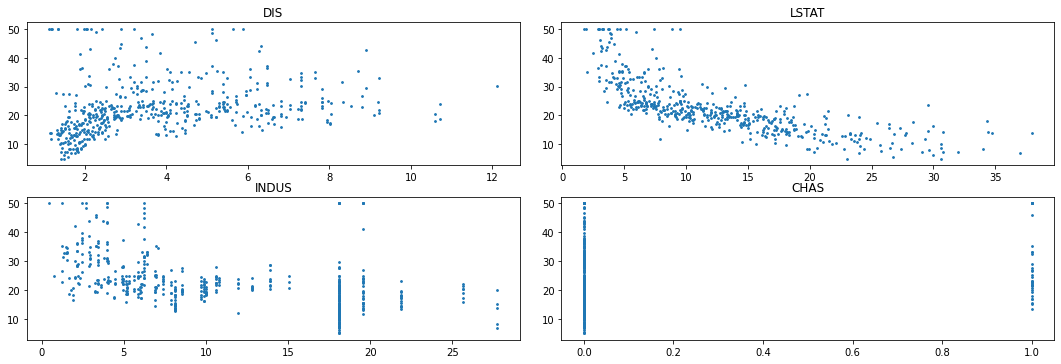

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(15,5))
fig.tight_layout()
area = np.pi*1
row,cols = [0,0]
y = target

for i in selections: 
  x = features[i]
  axs[row, cols].scatter(x,y, s = area)
  axs[row, cols].set_title(i)

  if row == 1:
    row,cols = [0,cols +1]
  else:
    row = row +1

***2) The mean of the residuals is zero***

In [57]:
model_residuals = np.array(fs_model.resid)
sum(model_residuals)/len(model_residuals)

1.758538976073836

**3) Homoscedasticity of residuals or equal variance**

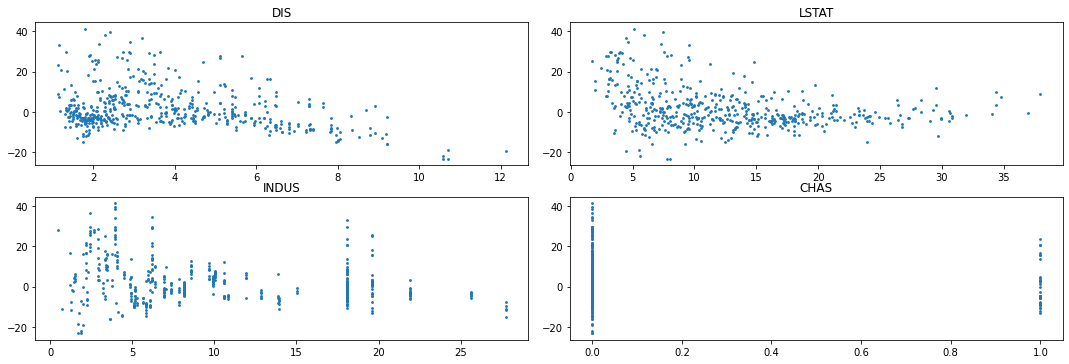

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(15,5))
fig.tight_layout()
area = np.pi*1
row,cols = [0,0]
y = model_residuals

for i in selections: 
  x = features[i]
  axs[row, cols].scatter(x,y, s = area)
  axs[row, cols].set_title(i)

  if row == 1:
    row,cols = [0,cols +1]
  else:
    row = row +1

Text(0.5, 24.0, 'residuals')

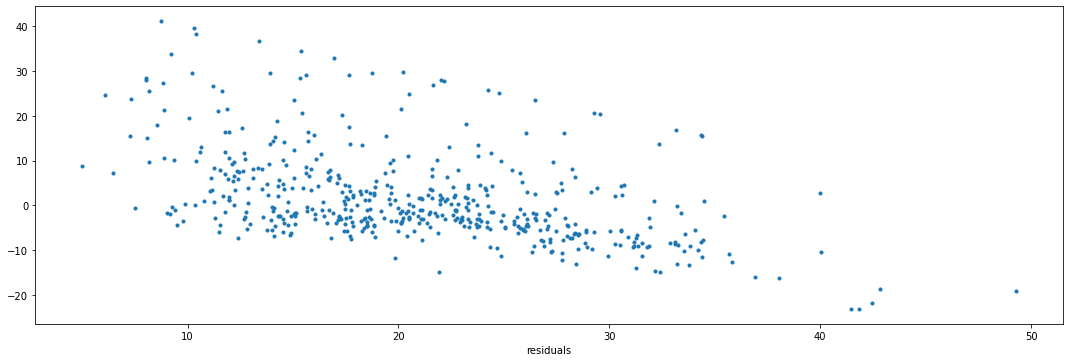

In [73]:
fig, axs = plt.subplots(2,1,figsize=(15,5), squeeze = False)
fig.tight_layout()
area = np.pi*3
x = fs_model.predict()
y = model_residuals
axs[0, 0].scatter(x,y, s = area)
axs[0, 0].set_xlabel('fitted values')
axs[0, 0].set_xlabel('residuals')

Looks like residuals decrease as the fitted values increase. I would hence conclude that the assumption is broken (is this correct?)

**4) No autocorrelation of residuals**

In [74]:
dw(model_residuals)

0.471248048848362

The Durbin-Watson test returns a value very close to 0 hence that could indicate positive autocorrelation. Based on this I conclude that this assumption has been broken.

The explanation of 'How to rectify' is unclear to me. I understand what needs to be done but don't understand why this solves the problem.

**5) The X variables and residuals are uncorrelated**

In [75]:
selections = [x for x in dict(fs_model.params)]

feature_df = features[selections]
corr = []
res = np.array(fs_model.resid)
for i in (list(feature_df.columns)):
  a = np.array(feature_df[i])
  var_corr = pearsonr(a,res)
  corr_element = [var_corr[1], var_corr[0], i]
  corr.append(corr_element)
corr.sort()

corr

[[9.29947848190716e-13, -0.3103308320777425, 'DIS'],
 [2.3166441402668825e-12, -0.3050982741336558, 'LSTAT'],
 [1.5516003222041308e-10, -0.2795245617190214, 'INDUS'],
 [0.2924395406267855, -0.046892225577132456, 'CHAS']]

Three out of the four selected variables are correlated with the error term. Could this be due to the fact that we kicked out too many variables to fix the problem of multicollinearity.

**6) The number of observations must be greater than the number of Xs**

We have 506 observations and estimate 4 Xs hence this assumption is fulfilled.

**7) The variability in X values is positive**

In [ ]:
var = [np.var(np.array(features[i])) for i in list(features.columns)]
var.sort()
var

[0.013401098888632846,
 0.06438547704229093,
 0.49269521612976297,
 4.425252261616491,
 4.677726296302081,
 46.97142974152072,
 50.893979351731794,
 73.84035966507905,
 75.66653126904029,
 542.8618397412864,
 790.7924728163227,
 8318.280420504929,
 28348.62359980628]

Fulfilled

**8) The regression model is correctly specified**

Simple tests to check if the model is specified correctly.
Use the F-Test/Cross-Validation.

**9) No perfect multicollinearity**

*   Multicollinearity does not affect the model's prediction strength
*   Multicollinearity affects the coefficient values for the predictor variables by inflating their importance
* Variables that do not cause multicollinearity have a VIF lower than 4.



In [21]:
selections = [x for x in dict(fs_model.params)]
feature_df = features[selections]
df = feature_df.to_numpy()
vif_values = [vif(df, i) for i in range(df.shape[1])]
vif_df = pd.DataFrame(list(feature_df.columns), columns = ['variables'])
vif_df['VIF'] = vif_values
vif_df.sort_values('VIF', ascending = False)

,variables,VIF
2,LSTAT,6.015082
1,INDUS,5.295752
0,DIS,1.719568
3,CHAS,1.080525


In [22]:
corr_matrix = pd.DataFrame(data = np.corrcoef(feature_df.T), index = list(feature_df.columns), columns = list(feature_df.columns))
corr_matrix

,DIS,INDUS,LSTAT,CHAS
DIS,1.000000,-0.708027,-0.496996,-0.099176
INDUS,-0.708027,1.000000,0.603800,0.062938
LSTAT,-0.496996,0.603800,1.000000,-0.053929
CHAS,-0.099176,0.062938,-0.053929,1.000000


**10) Normality of residuals**

In [78]:
df = pd.DataFrame(np.array(fs_model.resid), columns=['residuals']).sort_values(by = ['residuals'], ascending = True).reset_index()
df['count']= df.index + 1
df['percentile_area'] = (df['count'])/(df.shape[0])
df['z_theoretical'] = ndtri(df['percentile_area'])
df['z_actual'] = (df['residuals'] - df['residuals'].mean())/df['residuals'].std(ddof=0)

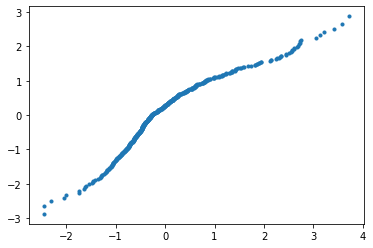

In [79]:
area = np.pi*3
plt.scatter(df.z_actual, df.z_theoretical, s = area)

Fulfilled